# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

# Imports

In [27]:
import tarfile
import os
import scipy.io
import skimage.io
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import rgb2gray
import skimage.morphology as mp
from skimage import measure

#import sys
from IPython.display import clear_output

In [5]:
data_base_path = os.path.join(os.pardir, 'data') # works for Herman
#data_base_path = ('data')
data_folder = 'project-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
#with tarfile.open(tar_path, mode='r:gz') as tar:
#    tar.extractall(path=data_base_path)

In [6]:
def load_images():

    train_dir = os.path.join(data_base_path, data_folder +'/images/train/')
    dir_train_list = sorted(os.listdir(train_dir))
    train = [skimage.io.imread(os.path.join(train_dir, file)) for file in dir_train_list]

    
    test_dir = os.path.join(data_base_path, data_folder +'/images/test/')
    dir_test_list = sorted(os.listdir(test_dir))
    test = [skimage.io.imread(os.path.join(test_dir, file)) for file in dir_test_list]
    
    val_dir = os.path.join(data_base_path, data_folder +'/images/validation/')
    dir_val_list = sorted(os.listdir(val_dir))
    validation = [skimage.io.imread(os.path.join(val_dir, file)) for file in dir_val_list]
    
    return train, test, validation

In [7]:
def parse_xml_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [8]:
train, test, validation = load_images()

In [9]:
def load_annotations():
    dir_train = os.path.join(data_base_path, data_folder + '/annotations/train/')
    dir_train_list = sorted(os.listdir(dir_train))
    train_files = [f for f in dir_train_list if os.path.isfile(os.path.join(dir_train, f))]
    train_annotations = [parse_xml_file(os.path.join(dir_train, file)) for file in train_files]
    
    
    dir_test = os.path.join(data_base_path, data_folder + '/annotations/test/')
    dir_test_list = sorted(os.listdir(dir_test))
    test_files = [f for f in dir_test_list if os.path.isfile(os.path.join(dir_test, f))]
    test_annotations = [parse_xml_file(os.path.join(dir_test, file)) for file in test_files]
    
    dir_val = os.path.join(data_base_path, data_folder + '/annotations/validation/')
    dir_val_list = sorted(os.listdir(dir_val))
    val_files = [f for f in dir_val_list if os.path.isfile(os.path.join(dir_val, f))]
    validation_annotations = [parse_xml_file(os.path.join(dir_val, file)) for file in val_files]
    
    return train_annotations, test_annotations, validation_annotations

In [10]:
train_annotations, test_annotations, validation_annotations = load_annotations()

# Preprocessing 


In [11]:
def remove_yellow(img):
    out = img.copy()
    
    red = out[:,:,0]
    green = out[:,:,1]
    blue = out[:,:,2]
    
    is_yellow =  (red > 100) & (red < 250) & (green > 100) & (green < 250) & (blue > 0) & (blue < 200)
    
    red[is_yellow] = 255
    green[is_yellow] = 255
    blue[is_yellow] = 255
    
    out[:,:,0] = red
    out[:,:,1] = green
    out[:,:,2] = blue
    
    return out

In [12]:
#Thresholding the image between two thresholds
def threshold(image, th1, th2):
    th_img = image.copy()
    th_img[th_img<th1] = 0
    th_img[th_img>th2] = 0
    th_img[(th_img>=th1) & (th_img<=th2)] = 255
    return th_img

In [13]:
def erode(img, nb):
    for i in range(nb):
        img = mp.erosion(mp.erosion(skimage.img_as_ubyte(img)))
    return img

In [14]:
def preprocess_image(img):
    img = remove_yellow(img)
    img_g = rgb2gray(img)
    img_th = threshold(skimage.img_as_ubyte(img_g), 1, 100)
    img_er = erode(img_th,1)
    return img_er

"""
def preprocess_image(img):
    img = remove_yellow(img)
    img_g = rgb2gray(img)
    img_th = mp.erosion(mp.erosion(threshold(skimage.img_as_ubyte(img_g), 1, 100)))
    return img_th
    """  

'\ndef preprocess_image(img):\n    img = remove_yellow(img)\n    img_g = rgb2gray(img)\n    img_th = mp.erosion(mp.erosion(threshold(skimage.img_as_ubyte(img_g), 1, 100)))\n    return img_th\n    '

In [15]:
def preprocess_images(train, test, validation):
    for i in range(len(train)):
        train[i] = preprocess_image(train[i])
        
    for i in range(len(test)):
        test[i] = preprocess_image(test[i])
        
    for i in range(len(validation)):
        validation[i] = preprocess_image(validation[i])
         
    return train, test, validation


In [16]:
train_pro, test_pro, validation_pro = preprocess_images(train, test, validation[0:2])

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [17]:
print("Nb train images     : {}".format(len(train_pro)))
print("Nb test images      : {}".format(len(test_pro)))
print("Nb validation images: {}".format(len(validation_pro)))

Nb train images     : 800
Nb test images      : 50
Nb validation images: 2


## Validation function

In [38]:
def validate_method(method, nb_test_images = None, printVals = False):
    def precision(tp, fp): return tp / (tp + fp)

    def recall(tp, fn): return tp / (tp + fn)

    def f1_score(tp, fp, fn):
        if (tp == 0): return 0
        return 2 * precision(tp, fp) * recall(tp, fn) / (precision(tp, fp) + recall(tp, fn))

    def iou_bbox(predict, true):
        """
        Calculate the IoU for two bounding boxes.
        Based on:
        https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
        """

        # Determine the coordinates of the intersection rectangle
        x_left   = max(predict[0], true[0])
        y_bottom = max(predict[1], true[1])
        x_right  = min(predict[0] + predict[2], true[0] + true[2])
        y_top    = min(predict[1] + predict[3], true[1] + true[3])

        # If they do not overlap, return 0
        if x_right < x_left or y_bottom > y_top:
            return 0.0

        intersection_area = (x_right - x_left) * (y_top - y_bottom)

        # Compute area for both bounding boxes
        bb1_area = predict[2] * predict[3]
        bb2_area = true[2] * true[3]

        # Compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the intersection area
        iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

        return iou
    
    def update_progress(progress):
        bar_length = 30
        if isinstance(progress, int):
            progress = float(progress)
        if not isinstance(progress, float):
            progress = 0
        if progress < 0:
            progress = 0
        if progress >= 1:
            progress = 1
            
        block = int(round(bar_length * progress))
        clear_output(wait = True)
        text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
        print(text)

    tp = 0
    fp = 0
    fn = 0
    
    # setup progress bar
    limit = len(test_pro[:nb_test_images] if nb_test_images != None else test_pro)

    for i in range(limit):
        update_progress(i/limit)
        # predict varroas
        varroas_pred = method(test_pro[i])

        # get true bounding boxes
        varroas_true = []
        for bbox in test_annotations[i]:
               varroas_true.append(bbox['bbox'])

        # get true and false positives
        positives = []

        for pb in varroas_pred:
            true_pos = False

            for tb in varroas_true:
                if(iou_bbox(pb, tb) > 0.3):
                    true_pos = True
                    break;
            positives.append(true_pos)

        tp += positives.count(True)
        fp += positives.count(False)

        # get the false negatives
        negatives = []

        for tb in varroas_true:
            fn = False

            for pb in varroas_pred:
                if(iou_bbox(pb, tb) > 0.3):
                    fn = True
                    break;
            negatives.append(fn)

        # Count all times no intersection was found
        fn += negatives.count(False)
    update_progress(1)
    
    if printVals :
        print('The values for the given test images')
        print(tp)
        print(fn)
        print(fp)

    
    print("\n----------- SCORES -----------")
    print("Precision: {}".format(precision(tp,fp)))
    print("Recall   : {}".format(recall(tp,fn)))
    print("F1-score : {}".format(f1_score(tp,fp,fn)))
    print("------------------------------")

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [19]:
def find_contours(img):
    contours = measure.find_contours(img, 0)
    lengths = []
    for cnt in contours:
        lengths.append(len(cnt))
    return contours, lengths

In [20]:
def contour_threshold_length(contours, th_low = 0, th_high = np.Inf) :
    # filters list of contours, keeps those within threshold limits
    out = []
    for n, contour in enumerate(contours):
        if len(contour) > th_low and len(contour) < th_high :
            out.append(contour)
    return out, len(out)

In [21]:
def contours2boxlist(contours):
    boxes = []
    for contour in contours :
        x_min = int(np.min(contour[:,1]))
        x_max = int(np.max(contour[:,1]))
        y_min = int(np.min(contour[:,0]))
        y_max = int(np.max(contour[:,0]))
        
        boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])
    
    return boxes # [[x_1, y_1, w_1, h_2]

In [22]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    #img = preprocess_image(img)
    contours,_ = find_contours(img)
    contours,_ = contour_threshold_length(contours,40,80)
    boxlist = contours2boxlist(contours)
    
    return boxlist

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [39]:
#Your code
validate_method(detect_by_segmentation)

Progress: [##############################] 100.0%

----------- SCORES -----------
Precision: 0.04203670811130847
Recall   : 0.9861111111111112
F1-score : 0.08063600227143669
------------------------------


## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [15]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code


Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

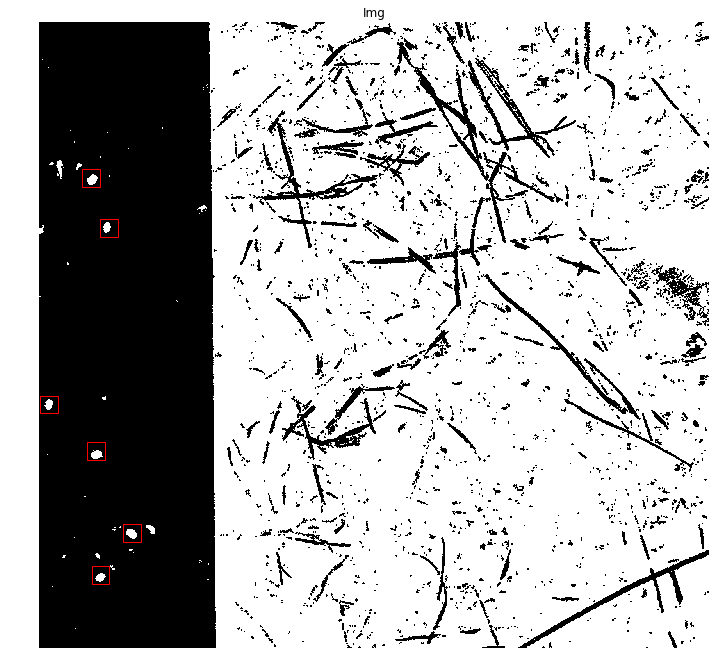

In [201]:
# Plot images
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# Iterate over annotations
for anno in test_annotations[3]:
    rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

ax.imshow(test[3],cmap='gray')
ax.axis('off')
ax.set_title('Img')
plt.show()

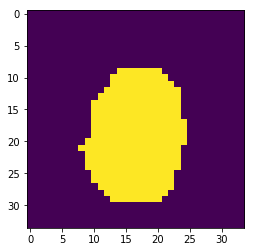

In [17]:
#Your code
bbox = train_annotations[0][0]['bbox']
plt.imshow(train[0][bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]])
#cv2.drawContours(image=ic, contours=contours, contourIdx=-1, color=(0,255,0), thickness=1)

#plt.imshow(ic, cmap='gray')

In [18]:
def get_window_size(annotations):
    width = []
    height = []
    for i in range(len(annotations)):
        for anno in annotations[i]:
            bbox = anno['bbox']
            width.append(bbox[2])
            height.append(bbox[3])
            
    avg_width = int(np.round(np.mean(width)))
    avg_height = int(np.round(np.mean(height)))
    return avg_width, avg_height

In [19]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [36]:
def get_contours_fake(images, annotations):
    max_len = 0
    all_contours = []
    w_width, w_height = get_window_size(annotations)
    
    for i in range(len(images)):
        for window in sliding_window(images[i], int((w_width/3)*2), (w_width, w_height)):
            im_bw = window[2]

            # Find contours using opencv
            _, contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            # Reshape to easily get x and y
            if (len(contours) == 0):
                contours_np = np.array([[0, 0]])
                all_contours.append(contours_np)
            else:
                contours_np = contours[0][:, 0, :]
                all_contours.append(contours_np)
        
            if (max_len < contours_np.shape[0]):
                max_len = contours_np.shape[0]

    return max_len, np.array(all_contours)             

In [37]:
empty_anno_index = []
for i in range(len(train_annotations)):
    if len(train_annotations[i]) == 0:
        empty_anno_index.append(i)
empty_anno_index = empty_anno_index[:5]
empty_anno_index
empty_pics = [train_pro[i] for i in empty_anno_index]

In [38]:
def get_contours(images, annotations):
    max_len = 0
    all_contours = []
    
    for i in range(len(images)):
        for anno in annotations[i]:
            bbox = anno['bbox']
            img_box = images[i][bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]].copy()
            im_bw = img_box

            # Find contours using opencv
            _, contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            # Reshape to easily get x and y
            if (len(contours) != 0):
                contours_np = contours[0][:, 0, :]
                all_contours.append(contours_np)

                if (max_len < contours_np.shape[0]):
                    max_len = contours_np.shape[0]

    return max_len, np.array(all_contours)

In [217]:
for anno in train_annotations[1]:
    bbox = anno['bbox']
    img_box = train[1][bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]].copy()
    im_bw = img_box

    # Find contours using opencv
    _, contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print(np.array(contours).shape)
    
    # Reshape to easily get x and y
    if (len(contours) != 0):
        contours_np = contours[0][:, 0, :]


(1, 53, 1, 2)


In [39]:
def fourier_descriptor(contours_np, length):
    
    # Pad contour to max contour length
    for i in range(length - len(contours_np)):
        contours_np = np.concatenate([contours_np, np.array([[0, 0]])])
    
    # Create imag nums and descriptors
    u_k = contours_np[:, 0] + 1j*contours_np[:, 1]
    
    fr = np.fft.fft(u_k)
    
    # Only return the 2nd and 3rd
    return [fr[1], fr[2], fr[3], fr[4], fr[5], fr[6]]

In [118]:
max_len_fake, contours_fake = get_contours_fake(empty_pics, train_annotations)
max_len, contours = get_contours(train_pro, train_annotations)

features_real = np.abs([(fourier_descriptor(c, max(max_len, max_len_fake))) for c in contours])
features_fake = np.abs([(fourier_descriptor(c, max(max_len, max_len_fake))) for c in contours_fake])

In [119]:
features_real = np.c_[ features_real, np.zeros(features_real.shape[0]) ]  
features_fake = np.c_[ features_fake, np.ones(features_fake.shape[0])]
train_features = np.vstack((features_real, features_fake))
scaler = preprocessing.StandardScaler().fit(train_features[:, 0:6])
train_features_s = scaler.transform(train_features[:, 0:6])
train_features_s.mean(axis=0)

array([-1.05565764e-13, -3.07972234e-14, -4.50542272e-14, -1.77909765e-14,
        1.05394350e-13, -4.78249579e-14])

In [26]:
def plot_descriptors(X_zeros, Y_zeros, X_ones, Y_ones):
    fig, ax = plt.subplots(1, 1)
    ax.scatter(X_zeros, Y_zeros, marker='o', color='red', label='Real')
    ax.scatter(X_ones, Y_ones, marker='^', color='blue', label='Fake')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    plt.show()

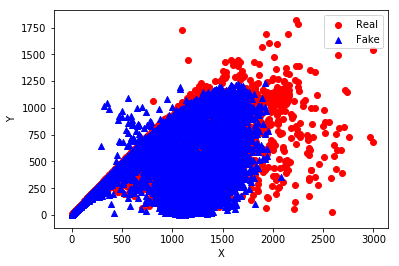

In [27]:
plot_descriptors(features_real[:, 0], features_real[:, 1], features_fake[:, 0], features_fake[:, 1])

In [28]:
def plot_descriptors_3D(class0, class1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(class0[:,0], class0[:,1], class0[:,2], marker='o', color='red', label='Real')
    ax.scatter(class1[:,0], class1[:,1], class1[:,2], marker='^', color='blue', label='Fake')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

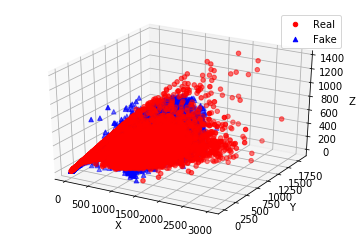

In [29]:
plot_descriptors_3D(features_real, features_fake)

In [120]:
clf = GaussianNB()
clf.fit(train_features[:, 0:6], train_features[:, 6])

GaussianNB(priors=None, var_smoothing=1e-09)

In [121]:
clf.score(train_features[:, 0:6], train_features[:, 6])

0.81788822480864

In [122]:
train_features.shape

(47685, 7)

In [123]:
from sklearn import svm
clf_svm = svm.SVC(probability=True, class_weight='balanced')
clf_svm.fit(train_features[:, 0:6], train_features[:, 6])

/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [124]:
clf_svm.score(train_features[:, 0:6], train_features[:, 6])

0.9387228688266751

In [167]:
scaler1 = preprocessing.StandardScaler().fit(features_real[:, 0:6])
features_real_s = scaler1.transform(features_real[:, 0:6])
features_fake_s = scaler1.transform(features_fake[:, 0:6])
clf_svm_one = svm.OneClassSVM(nu=0.9)
clf_svm_one.fit(features_real_s)
pred = clf_svm_one.predict(features_fake_s[:, 0:6])

In [ ]:
 prob = clf_svm_one.predict(test_.reshape(1, -1))[0][0]

In [168]:
np.unique(pred, return_counts=True)

(array([-1,  1]), array([40212,     6]))

# Test the detection

In [192]:
def precision(tp, fp):
    return tp / (tp + fp)

In [193]:
def recall(tp, fn):
    return tp / (tp + fn)

In [194]:
def f1_score(tp, fp, fn):
    if (tp == 0):
        return 0
    return 2 * precision(tp, fp) * recall(tp, fn) / (precision(tp, fp) + recall(tp, fn))

In [237]:
def iou_bbox(predict, true):
    """
    Calculate the IoU for two bounding boxes.
    Based on:
    https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    """
    
    # Determine the coordinates of the intersection rectangle
    x_left = max(predict[0], true[0])
    y_top = max(predict[1], true[1])
    x_right = min(predict[0] + predict[2], true[0] + true[2])
    y_bottom = min(predict[1] + predict[3], true[1] + true[3])
    
    # If they do not overlap, return 0
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Compute area for both bounding boxes
    bb1_area = predict[2] * predict[3]
    bb2_area = true[2] * true[3]

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    return iou

In [131]:
def detect_by_method_1_ver1(image):
    window_shape = (30, 30)
    padding = max(max_len, max_len_fake)
    varroas = []
    for window in sliding_window(image, int((window_shape[0]/3)*2), window_shape):
        im_bw = window[2]

        # Find contours using opencv
        _, contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        #print(len(contours))

        # Reshape to easily get x and y
        if (len(contours) > 0):
            contours_np = contours[0][:, 0, :]
            descriptor = np.abs(fourier_descriptor(contours_np, padding))
            test_ = scaler.transform(np.array([descriptor[:]]))
            #prob = clf_svm.predict_proba(np.array([[descriptor[0], descriptor[1], descriptor[2]]]))[0][0]
            prob = clf_svm.predict_proba(test_.reshape(1, -1))[0][0]
            # print(prob)
            if (prob > 0.60):
                varroas.append([window[0], window[1], window_shape[0], window_shape[1]])

    return varroas

In [294]:
def detect_by_method_1_ver2(image):
    window_shape = (45, 45)
    padding = max(max_len, max_len_fake)
    varroas = []
    for window in sliding_window(image, 6, window_shape):
        im_bw = window[2]

        # Find contours using opencv
        _, contours, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        #print(len(contours))

        # Reshape to easily get x and y
        if (len(contours) > 0):
            contours_np = contours[0][:, 0, :]
            descriptor = np.abs(fourier_descriptor(contours_np, padding))
            test_ = scaler1.transform(np.array([descriptor[:]]))
            #prob = clf_svm.predict_proba(np.array([[descriptor[0], descriptor[1], descriptor[2]]]))[0][0]
            prob = clf_svm_one.predict(test_.reshape(1, -1))
            # print(prob)
            if (prob > 0):
                varroas.append([window[0], window[1], window_shape[0], window_shape[1]])

    return merge_boxes(varroas)

In [295]:
def merge_boxes(bbox1):
    bboxes = bbox1.copy()
    for i in range(len(bboxes)):
        for j in range(i+1, len(bboxes)):
            if(iou_bbox(bboxes[i], bboxes[j]) > 0.3):

                # Determine the coordinates of the intersection rectangle
                x_left = min(bboxes[i][0], bboxes[j][0])
                y_top = min(bboxes[i][1], bboxes[j][1])
                x_right = max(bboxes[i][0] + bboxes[i][2], bboxes[j][0] + bboxes[j][2])
                y_bottom = max(bboxes[i][1] + bboxes[i][3], bboxes[j][1] + bboxes[j][3])
                
                bboxes[j] = [x_left, y_top, x_right - x_left, y_bottom - y_top]
                del bboxes[i]
                break
    return bboxes

In [297]:
tp = 0
fp = 0
fn = 0

for i in range(len(test_pro[0:25])):
    # predict varroas
    varroas_pred = detect_by_method_1_ver2(test_pro[i])
    
    # get true bounding boxes
    varroas_true = []
    for bbox in test_annotations[i]:
           varroas_true.append(bbox['bbox'])
    
    # get true and false positives
    positives = []
    
    for pb in varroas_pred:
        true_pos = False
        
        for tb in varroas_true:
            #print(pb)
            #print(tb)
            if(iou_bbox(pb, tb) > 0.3):
                true_pos = True
                break;
        positives.append(true_pos)
    
    tp += positives.count(True)
    fp += positives.count(False)
    
    # get the false negatives
    negatives = []
    
    for tb in varroas_true:
        fn = False
        
        for pb in varroas_pred:
            if(iou_bbox(pb, tb) > 0.3):
                fn = True
                break;
        negatives.append(fn)
    
    # Count all times no intersection was found
    fn += negatives.count(False)

print('The values for the given test images')
print(tp)
print(fn)
print(fp)

# Calculate precision and recall
precision_ = precision(tp, fp)
recall_ = recall(tp, fn)
    
print('The values for the given test images')
print('Precision %f' % precision_)
print('Recall %f' % recall_)
print('F1-Score %f\n' % f1_score(tp, fp, fn))

The values for the given test images
78
30
309
The values for the given test images
Precision 0.201550
Recall 0.722222
F1-Score 0.315152



In [ ]:
# Plot images
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

varroas_pred_merged, varroas_pred = detect_by_method_1_ver2(test_pro[3])
# Iterate over annotations
for anno in varroas_pred:
    rect = patches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
            linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

for anno in varroas_pred_merged:
    rect = patches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
            linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rect)


# Iterate over annotations
for anno in test_annotations[3]:
    rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

ax.imshow(test[3], cmap='gray')
ax.axis('off')
ax.set_title('Img')
plt.show()

In [282]:
tp = 0
fn = 0
fp = 0

# get true bounding boxes
varroas_true = []
for bbox in test_annotations[3]:
       varroas_true.append(bbox['bbox'])

# get true and false positives
positives = []

for pb in varroas_pred:
    true_pos = False

    for tb in varroas_true:
        if(iou_bbox(pb, tb) > 0.3):
            true_pos = True
            break;
    positives.append(true_pos)

tp += positives.count(True)
fp += positives.count(False)

# get the false negatives
negatives = []

for tb in varroas_true:
    fn = False

    for pb in varroas_pred:
        if(iou_bbox(pb, tb) > 0.3):
            fn = True
            break;
    negatives.append(fn)

# Count all times no intersection was found
fn += negatives.count(False)

In [283]:
tp

6

In [286]:
varroas_pred_merged

[[132, 384, 45, 51],
 [162, 510, 51, 45],
 [18, 960, 45, 51],
 [144, 1092, 45, 45],
 [270, 1290, 45, 45],
 [150, 1404, 51, 45],
 [138, 1416, 51, 45]]

In [284]:
varroas_pred

[[132, 384, 45, 45],
 [132, 390, 45, 45],
 [162, 510, 45, 45],
 [168, 510, 45, 45],
 [18, 960, 45, 45],
 [18, 966, 45, 45],
 [144, 1092, 45, 45],
 [270, 1290, 45, 45],
 [150, 1404, 45, 45],
 [156, 1404, 45, 45],
 [138, 1416, 45, 45],
 [144, 1416, 45, 45]]

In [285]:
varroas_true

[[108, 376, 46, 45],
 [154, 503, 46, 46],
 [2, 957, 46, 45],
 [121, 1074, 46, 46],
 [213, 1285, 46, 46],
 [133, 1394, 46, 46]]

# Future problem

In [46]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [49]:
windows = sliding_window(train[2], 100, (300, 300))

In [52]:
import argparse
import time
import cv2
(winW, winH) = (300, 300)

In [54]:
for (x, y, window) in sliding_window(train[2], 100, (winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue

    # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
    # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
    # WINDOW



KeyboardInterrupt: 

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [5]:
#Your code

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code

## Appendix: plotting functions

In [14]:
def plot_image(img):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    size = img.shape
    if len(size) == 3:
        ax.imshow(img)
        ax.set_title('({} px, {} px, depth {})'.format(size[0], size[1], size[2]))
    else:
        ax.imshow(img, cmap='gray')
        ax.set_title('({} px, {} px), single channel'.format(size[0], size[1]))
    plt.show()

In [24]:
def plot_with_annotation(img_nb, annotations, img = None):
    if annotations == [] : 
        print("No varroa here!")
        return None
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], 
                                  anno['bbox'][1]), 
                                  anno['bbox'][2],
                                  anno['bbox'][3],
            linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    if img is not None: # img from argument
        size = img.shape
        if len(size) == 3:
            ax.imshow(img)
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px, depth {})'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1], size[2]))
        else:
            ax.imshow(img, cmap='gray')
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px), single channel'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1]))
    else: # image from collection
        size = img_collection[img_nb].shape
        if len(size) == 3:
            ax.imshow(img_collection[img_nb])
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px, depth {})'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1], size[2]))
        else:
            ax.imshow(img_collection[img_nb], cmap='gray')
            ax.set_title('img nb {}, no varroae {}, ({} px, {} px), single channel'.format(
                img_nb,len(annotations_xmls[img_nb]), size[0], size[1]))
    plt.show()

In [16]:
def plot_contours(img, th_low = 0, th_high = np.Inf):
    # Find contours
    contours,l = find_contours(img)
    plt.subplots(1,1,figsize=(6,6))

    plt.gca().invert_yaxis()
    
    contours,l = contour_threshold_length(contours, th_low, th_high)
    
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    plt.title("{} contours between threholds {} and {}".format(l,
                                                              th_low,
                                                              th_high))
    plt.show()

def plot_contours_histogram(img):
    _, lengths = find_contours(img)
    plt.subplots(1,1,figsize=(10,6))
    plt.hist(lengths, bins='auto')
    plt.title("Histogram with 'auto' bins")
    plt.show()

In [20]:
def plot_boxlist_and_annotations(img_nb, boxlist, annotations) :
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    
    # plot boxes
    tmp_im = np.zeros(img_collection[img_nb].shape)
    for box in boxlist:
        #print(box)
        for x in range(box[0], box[2] + box[0]) :
            for y in range(box[1], box[3] + box[1]):
                tmp_im[y,x] = 1.0
    ax.imshow(tmp_im, cmap = 'gray')
    
    # plot annotations
    if annotations != [] : 
        for anno in annotations:
            rect = patches.Rectangle((anno['bbox'][0], 
                                      anno['bbox'][1]), 
                                      anno['bbox'][2],
                                      anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        no_varroa = len(annotations)
    else:
        no_varroa = 0

    #ax.imshow(img_collection[img_nb], cmap='gray')
    ax.set_title('img nb {}, no varroae {}, no boxes {}'.format(
        img_nb,no_varroa, len(boxlist)))
    plt.show()

In [21]:
def plot_contours_and_annotations(img_nb, contours, annotations) :
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    
    # plot contours
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    # plot annotations
    if annotations != [] :
        for anno in annotations:
            rect = patches.Rectangle((anno['bbox'][0], 
                                      anno['bbox'][1]), 
                                      anno['bbox'][2],
                                      anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        no_varroa = len(annotations)
    else:
        no_varroa = 0

    #ax.imshow(img_collection[img_nb], cmap='gray')
    ax.set_title('img nb {}, no varroae {}, no contours {}'.format(
        img_nb,no_varroa, len(contours)))
    
    plt.gca().invert_yaxis()
    plt.show()